[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RichardJPovinelli/Neural_Networks_Course/blob/main/Attention_Heatmap_Shakespeare.ipynb)
# Attention Heatmap on Shakespeare (or your own text)

This notebook shows how tokens **attend** to each other in a pretrained transformer (GPT-2).  
You can paste your own Shakespeare passage (or any text) and generate an attention **heatmap**.

**What you'll do:**
1. Install dependencies (`transformers`, `torch`).
2. Paste text into `TEXT` below (default is a short, public-domain Shakespeare excerpt).
3. Run the model with `output_attentions=True`.
4. Plot a heatmap of attention weights (average over heads, choose layer).

> Tip: Keep the text short (e.g., 20–80 tokens) so labels remain readable.


## Setup environment

In [ ]:
import sys

if "google.colab" in sys.modules:
    print("Detected Google Colab runtime. Installing packages from requirements.txt...")
    target_python = sys.executable
    # pip can handle --extra-index-url if present in requirements.txt


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np

c:\Users\richard\mu\teaching\Neural Networks\lectures\jupyter_notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Paste your text (or use the default)

- Keep it relatively short for a clean heatmap (<= 80 tokens is ideal).  
- The default is public-domain Shakespeare.


In [ ]:
# Replace this with your own text (e.g., a Shakespeare passage you used in class)
TEXT = "To be, or not to be—that is the question:"

# Truncate very long text to avoid unreadable plots
MAX_TOKENS = 96  # adjust if needed
MODEL_NAME = "gpt2"  # small, fast; good for classroom demos

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, output_attentions=True).to(device).eval()

# Tokenize
enc = tokenizer(TEXT, return_tensors='pt', truncation=True, max_length=MAX_TOKENS, add_special_tokens=False)
input_ids = enc['input_ids'].to(device)

# Forward pass with attentions
with torch.no_grad():
    out = model(input_ids)
attentions = out.attentions  # tuple: (num_layers) of tensors (batch, num_heads, seq_len, seq_len)

num_layers = len(attentions)
num_heads = attentions[0].shape[1]
seq_len = attentions[0].shape[-1]

print(f'Device: {device}')
print(f'Layers: {num_layers}, Heads per layer: {num_heads}, Sequence length: {seq_len}')

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Device: cpu
Layers: 12, Heads per layer: 12, Sequence length: 52


In [ ]:

def decode_tokens(tokenizer, input_ids_tensor):
    ids = input_ids_tensor[0].tolist()
    toks = [tokenizer.convert_ids_to_tokens([i])[0] for i in ids]
    return toks

def plot_attention_heatmap(attn_matrix, tokens, title='Attention Heatmap (avg over heads)'):
    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots(figsize=(min(16, max(8, len(tokens) * 0.4)), 
                                    min(12, max(6, len(tokens) * 0.35)) ))
    im = ax.imshow(attn_matrix)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()

tokens = decode_tokens(tokenizer, input_ids)



## Plot: Average over heads for a chosen layer

Choose `LAYER_IDX` (0 = bottom, `num_layers-1` = top).  
This averages across all attention heads to give a single, readable heatmap.


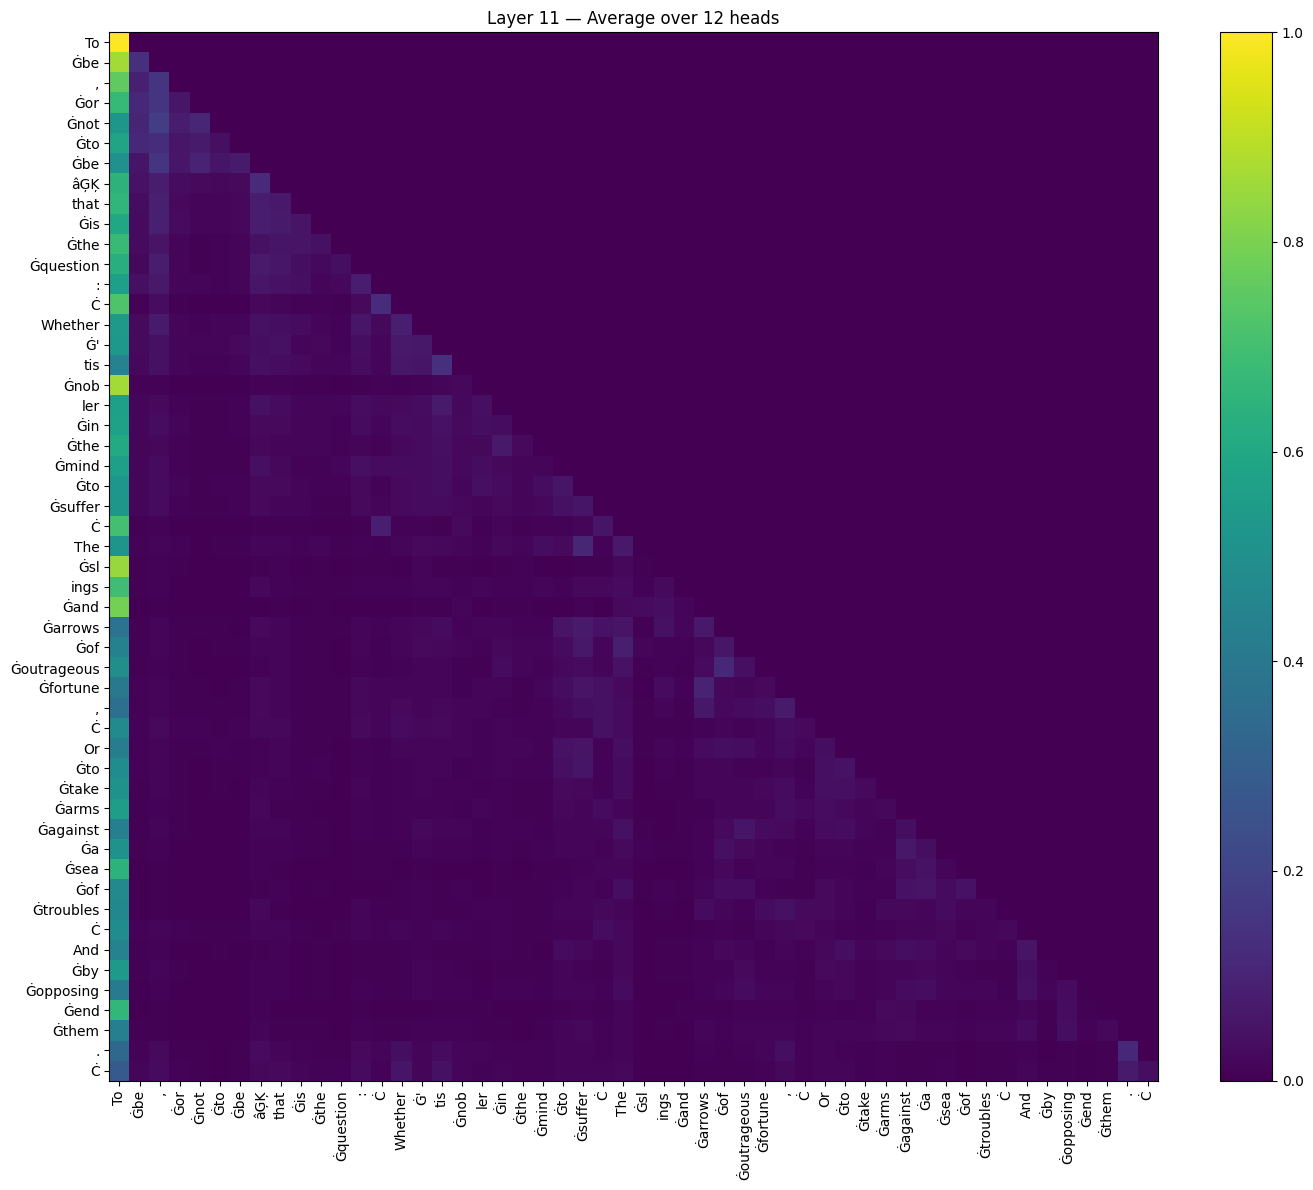

In [ ]:
# Choose which layer to visualize (0-indexed). Top layer often shows sharp patterns.
LAYER_IDX = -1  # last layer
layer_idx = LAYER_IDX if LAYER_IDX >= 0 else (len(attentions) + LAYER_IDX)

attn_layer = attentions[layer_idx][0]  # shape: (num_heads, seq_len, seq_len)
attn_avg = attn_layer.mean(dim=0).cpu().numpy()  # (seq_len, seq_len)

plot_attention_heatmap(attn_avg, tokens, title=f"Layer {layer_idx} — Average over {attn_layer.shape[0]} heads")


## (Optional) Inspect a specific head

Uncomment and run to see a single head's pattern.


In [ ]:
# HEAD_IDX = 0  # pick one head to inspect
# attn_head = attentions[layer_idx][0, HEAD_IDX].cpu().numpy()
# plot_attention_heatmap(attn_head, tokens, title=f"Layer {layer_idx} — Head {HEAD_IDX}")



## (Optional) Focus on a single token

Set `QUERY_INDEX` to a row index to see which prior tokens it pays attention to (GPT‑2 is causal).


In [ ]:
# QUERY_INDEX = 5  # change this to a valid token index
# row = attn_avg[QUERY_INDEX]  # shape: (seq_len,)
# fig, ax = plt.subplots(figsize=(12, 3))
# ax.bar(range(len(tokens)), row)
# ax.set_xticks(range(len(tokens)))
# ax.set_xticklabels(tokens, rotation=90)
# ax.set_title(f"Attention distribution for token index {QUERY_INDEX}: {tokens[QUERY_INDEX]}")
# fig.tight_layout()
# plt.show()